**Задание для выполнения в классе:** построить два списка, в одном из которых будут значения времени от 0 до `intensity.xmax` с шагом 0.01 с, а в другом &ndash; значения интенсивности в этих точках. Построить график с помощью `matplotlib`.

In [ ]:
!pip install praat-parselmouth

In [ ]:
!wget https://pkholyavin.github.io/mastersprogramming/cta0001.wav

In [12]:
import parselmouth
import numpy as np
import matplotlib.pyplot as plt

In [3]:
sound = parselmouth.Sound("cta0001.wav")
intensity = sound.to_intensity()

Чистый python:

In [15]:
times = [i * 0.01 for i in range(round(intensity.xmax / 0.01))]

numpy:

In [13]:
times = np.arange(0, intensity.xmax, 0.01)

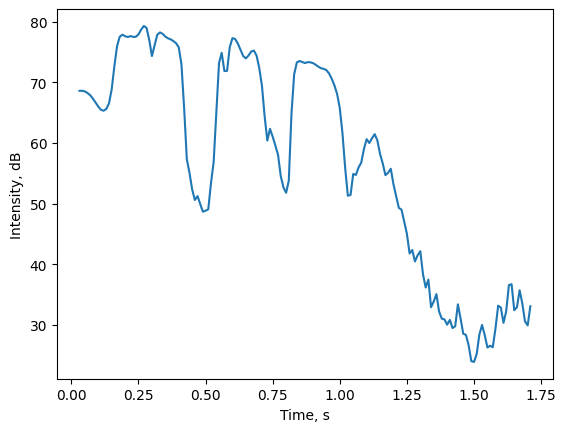

In [46]:
intens_values = [intensity.get_value(t) for t in times]
plt.plot(times, intens_values)
plt.xlabel("Time, s")
plt.ylabel("Intensity, dB")
plt.show()

**Задание для выполнения в классе:** прочитайте файл cta0001.seg_B1, определите место середины каждого звука, найдите значение ЧОТ в этом месте и постройте график, где на оси X по порядку будут отложены звуки, а на оси Y &ndash; ЧОТ в герцах.

In [ ]:
!wget https://pkholyavin.github.io/mastersprogramming/cta0001.seg_B1

In [17]:
from itertools import product
letters = "GBRY"
nums = "1234"
levels = [ch + num for num, ch in product(nums, letters)]
level_codes = [2 ** i for i in range(len(levels))]
code_to_level = {i: j for i, j in zip(level_codes, levels)}
level_to_code = {j: i for i, j in zip(level_codes, levels)}

In [18]:
def read_seg(filename: str, encoding: str = "utf-8-sig") -> tuple[dict, list[dict]]:
    with open(filename, encoding=encoding) as f:
        lines = [line.strip() for line in f.readlines()]

    # найдём границы секций в списке строк:
    header_start = lines.index("[PARAMETERS]") + 1
    data_start = lines.index("[LABELS]") + 1

    # прочитаем параметры
    params = {}
    for line in lines[header_start:data_start - 1]:
        key, value = line.split("=")
        params[key] = int(value)

    # прочитаем метки
    labels = []
    for line in lines[data_start:]:
        # если в строке нет запятых, значит, это не метка и метки закончились
        if line.count(",") < 2:
            break
        pos, level, name = line.split(",", maxsplit=2)
        label = {
            "position": int(pos) // params["BYTE_PER_SAMPLE"] // params["N_CHANNEL"],
            "level": code_to_level[int(level)],
            "name": name
        }
        labels.append(label)
    return params, labels

In [33]:
pitch = sound.to_pitch(pitch_floor=75, pitch_ceiling=400)

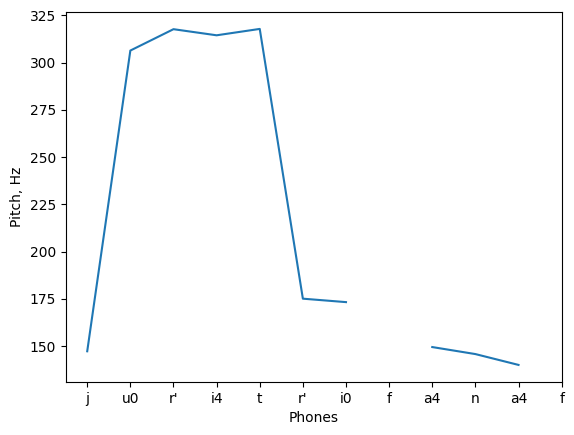

In [45]:
params, labels = read_seg("cta0001.seg_B1")
sounds = []
f0_values = []
for left, right in zip(labels, labels[1:]):
    sounds.append(left["name"])
    mid = (left["position"] + right["position"]) / 2 / params["SAMPLING_FREQ"]
    f0_values.append(pitch.get_value_at_time(mid))

plt.plot(f0_values)
plt.xticks(range(len(sounds)), labels=sounds)
plt.xlabel("Phones")
plt.ylabel("Pitch, Hz")
plt.show()

**Задание для выполнения в классе:** модифицировать код из предыдущего задания так, чтобы в трёх точках каждого гласного (1/4, 1/2 и 3/4 длины) вычислялись первая и вторая форманты. Нарисовать график.

In [36]:
formants = sound.to_formant_burg()

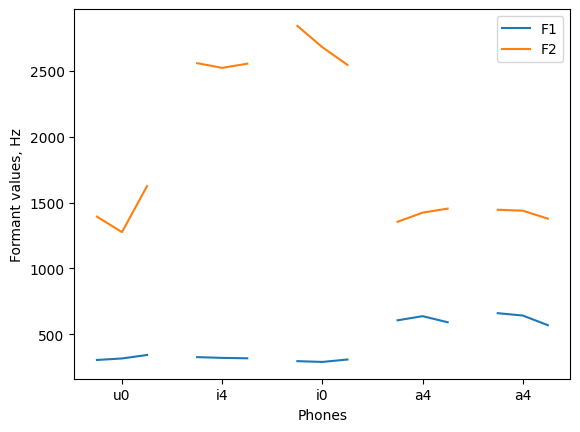

In [44]:
x_ticks = []
f1_values = []
f2_values = []

for left, right in zip(labels, labels[1:]):
    if not left["name"].startswith(tuple("ieaouy")):  # оставим только гласные
        continue
    x_ticks.append(left["name"])
    quarter_dur = (right["position"] - left["position"]) / 4 / params["SAMPLING_FREQ"]
    start_dur = left["position"] / params["SAMPLING_FREQ"]
    for i in range(1, 4):
        f1_values.append(formants.get_value_at_time(1, start_dur + quarter_dur * i))
        f2_values.append(formants.get_value_at_time(2, start_dur + quarter_dur * i))
    f1_values.append(np.nan)  # вставим дырки для удобства визуализации
    f2_values.append(np.nan)

plt.plot(f1_values, label="F1")
plt.plot(f2_values, label="F2")
xtick_locations = range(1, len(f1_values), 4)  # оставим засечки на оси X только в середине каждого звука (каждая четвёртая точка, начиная со второй)
plt.xticks(xtick_locations, labels=x_ticks)
plt.xlabel("Phones")
plt.ylabel("Formant values, Hz")
plt.legend()  # легенда графика из лейблов
plt.show()